<a href="https://colab.research.google.com/github/rmahesh6386/Tata-Motors-Project-/blob/main/TATA_Motors_Stock_market_Forecasting_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [160]:
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use("ggplot")

%matplotlib inline

In [162]:
plt.rcParams["figure.figsize"] = (12, 6)

In [163]:
# For reading stock data from yahoo
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

# For time stamps
from datetime import datetime

# For division
from __future__ import division

In [164]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
dt = datetime.now()
end = datetime(dt.year,dt.month,dt.day-10)
start = datetime(end.year-10,end.month,end.day)

# Set DataFrame as the Stock Ticker
df = pdr.get_data_yahoo(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [165]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-07-18,221.375519,221.523941,216.082306,219.248337,216.751236,11897419
2012-07-19,222.117569,224.096344,221.424988,222.414383,219.881226,6677436
2012-07-20,221.622879,223.057480,219.693573,221.029236,218.511856,3940979
2012-07-23,218.555771,218.654709,212.718384,213.757233,211.322693,5761220
2012-07-24,214.202469,215.488663,211.085892,213.559357,211.127060,7368372


In [166]:
df.index

DatetimeIndex(['2012-07-18', '2012-07-19', '2012-07-20', '2012-07-23',
               '2012-07-24', '2012-07-25', '2012-07-26', '2012-07-27',
               '2012-07-30', '2012-07-31',
               ...
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15'],
              dtype='datetime64[ns]', name='Date', length=2463, freq=None)

Check whether you have duplicate data on by date

In [167]:
df[df.index.duplicated(keep = False)]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


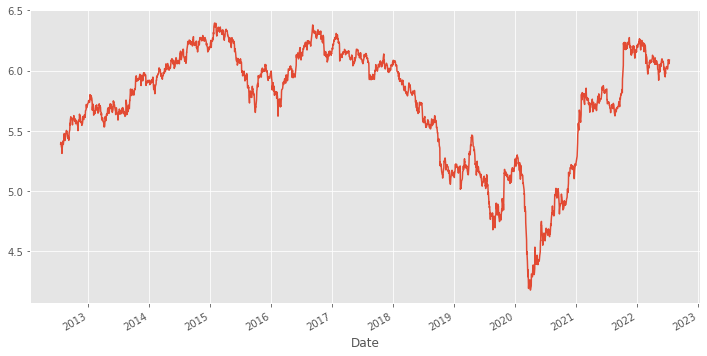

In [168]:
y = np.log(df["Close"])
y.plot()

In [169]:
y.index

DatetimeIndex(['2012-07-18', '2012-07-19', '2012-07-20', '2012-07-23',
               '2012-07-24', '2012-07-25', '2012-07-26', '2012-07-27',
               '2012-07-30', '2012-07-31',
               ...
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-11', '2022-07-12', '2022-07-13',
               '2022-07-14', '2022-07-15'],
              dtype='datetime64[ns]', name='Date', length=2463, freq=None)

Calculate rolling mean, exponentially weighted mean

In [170]:
period = 100
y_rolling = pd.DataFrame(dict(actual = y, 
                              rolling_mean = y.rolling(period).mean(), 
                              ewm = y.ewm(span = period).mean()
                             ))
y_rolling.tail()

,actual,rolling_mean,ewm
Date,,,
2022-07-11,6.080048,6.059562,6.055016
2022-07-12,6.065063,6.057987,6.055215
2022-07-13,6.057018,6.056442,6.055250
2022-07-14,6.059240,6.054889,6.055329
2022-07-15,6.087229,6.053753,6.055961


In [171]:
rolling_dropped = y_rolling.dropna()
print("rmse over rolling mean: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped.rolling_mean) ** 0.5)
print("rmse over ewma: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped["ewm"]) ** 0.5)

rmse over rolling mean:  0.18606566333622673
rmse over ewma:  0.1581524413253412


By visual inspection, we see the time series is not stationary. Let we will see a more formal way of testing using Dickey Fullter Test.

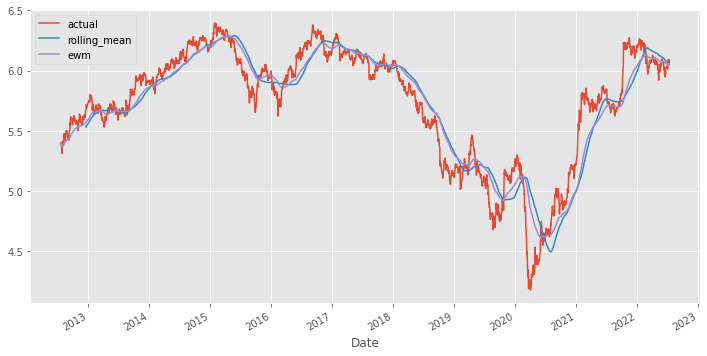

In [172]:
y_rolling.plot()

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05, we can say that there is not sufficient proof that the time series is stationary. Loosely speaking, it is non-stationary. We need further transformation to make data stationary. Populary method for making data stationary will be to take "difference". Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. So we conclude, diff 1 has made the data stationary.

In [173]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.dropna())

ADF Statistic: -1.393212
p-value: 0.585526
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Non-stationary


In [174]:
diff = pd.DataFrame({"actual": y, "diff1": y.diff(3)}).head(10)
diff["diff2"] = diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2012-07-18,5.390205,NaN,NaN
2012-07-19,5.404542,NaN,NaN
2012-07-20,5.398295,NaN,NaN
2012-07-23,5.364841,-0.025364,NaN
2012-07-24,5.363915,-0.040627,-0.015263
2012-07-25,5.350623,-0.047672,-0.007044
2012-07-26,5.312829,-0.052012,-0.004340
2012-07-27,5.349919,-0.013996,0.038016
2012-07-30,5.390656,0.040033,0.054029


In [175]:
def check_stationarity(series):
    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(y.diff(periods=1).dropna())

ADF Statistic: -48.545850
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Stationary


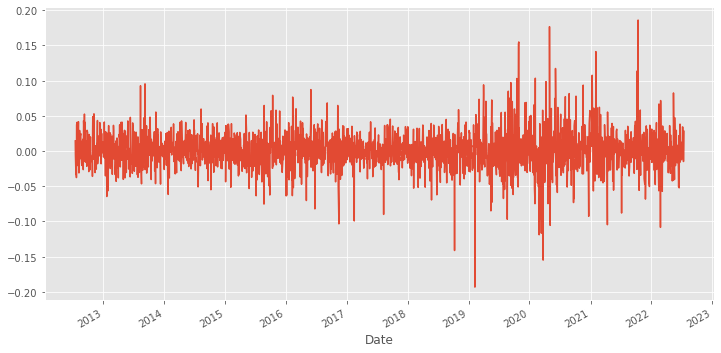

In [176]:
y.diff(periods=1).plot()

Use pandas's auto correlation plot. Here is a nice explanation of the autocorrelation plot

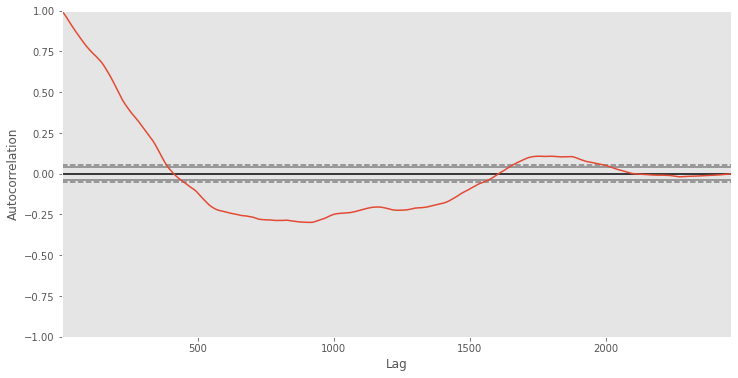

In [177]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [178]:
y = y.dropna()

In [179]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

model_autoARIMA = auto_arima(y, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10817.813, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10816.907, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10816.890, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10819.540, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10815.118, Time=1.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.443 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 2463
Model:               SARIMAX(0, 1, 0)   Log Likelihood                5410.770
Date:                Thu, 28 Jul 2022   AIC                         -10819.540
Time:                        04:13:34   BIC                         -10813.731
Sample:                             0   HQIC                        -10817.429
                               - 2463                             

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                  0
count  2.462000e+03
mean   5.706380e-10
std    2.687647e-02
min   -1.936582e-01
25%   -1.361539e-02
50%   -2.831124e-04
75%    1.322949e-02
max    1.857541e-01


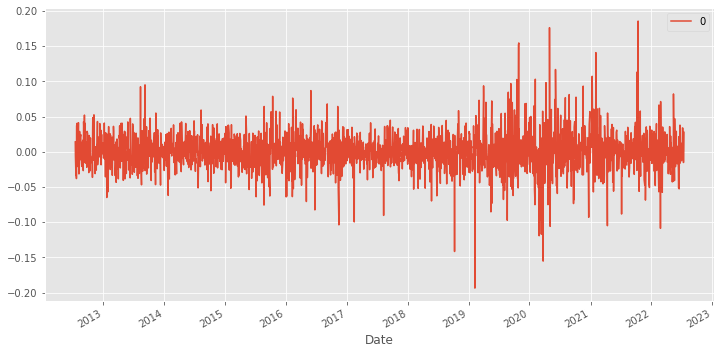

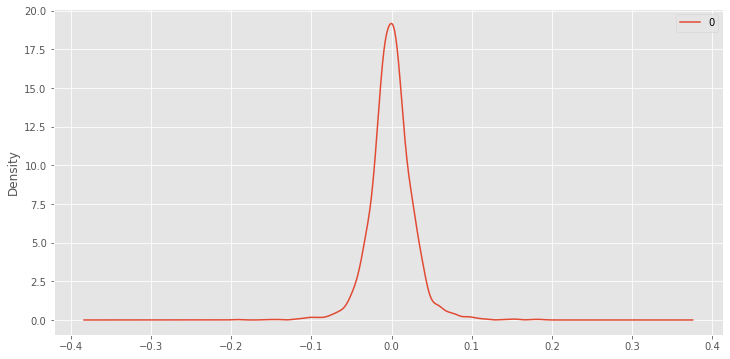

In [180]:
from statsmodels.tsa.arima_model import ARIMA

p=0
d=1
q=0

# fit model
model = ARIMA(y, order=(p, d, q)) 
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [181]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 2462
Model:                 ARIMA(0, 1, 0)   Log Likelihood                5410.907
Method:                           css   S.D. of innovations              0.027
Date:                Thu, 28 Jul 2022   AIC                         -10817.813
Time:                        04:13:35   BIC                         -10806.196
Sample:                             1   HQIC                        -10813.592
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.523      0.601      -0.001       0.001
==============================================================================
"""

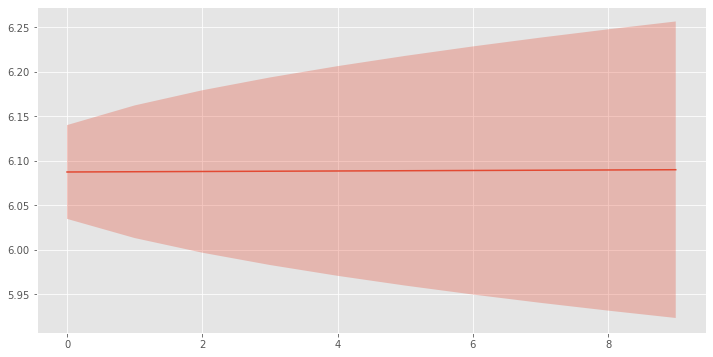

In [182]:
model = ARIMA(y.values, order=(p, d, q))
model_fit = model.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(10)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [183]:
predictions[:10]

array([6.08751231, 6.08779542, 6.08807853, 6.08836165, 6.08864476,
       6.08892787, 6.08921098, 6.0894941 , 6.08977721, 6.09006032])

In [184]:
from sklearn.metrics import mean_squared_error

x = y.values
train_size = int(len(x) * 0.7)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

predicted=5.050940, actual=5.018934
predicted=5.018719, actual=4.971894
predicted=4.971652, actual=4.991452
predicted=4.991221, actual=4.923988
predicted=4.923718, actual=4.893727
predicted=4.893440, actual=4.909709
predicted=4.909432, actual=4.864067
predicted=4.863763, actual=4.872905
predicted=4.872606, actual=4.818263
predicted=4.817933, actual=4.808111
predicted=4.807775, actual=4.765587
predicted=4.765227, actual=4.820685
predicted=4.820356, actual=4.804431
predicted=4.804093, actual=4.803611
predicted=4.803273, actual=4.794964
predicted=4.794621, actual=4.798679
predicted=4.798339, actual=4.794136
predicted=4.793794, actual=4.819071
predicted=4.818743, actual=4.722064
predicted=4.721680, actual=4.679350
predicted=4.678942, actual=4.709981


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.709591, actual=4.705468
predicted=4.705076, actual=4.790404
predicted=4.790061, actual=4.756603
predicted=4.756240, actual=4.738827
predicted=4.738454, actual=4.759607
predicted=4.759246, actual=4.724286
predicted=4.723905, actual=4.695925
predicted=4.695528, actual=4.771108
predicted=4.770755, actual=4.797855
predicted=4.797517, actual=4.803201
predicted=4.802866, actual=4.900448
predicted=4.900169, actual=4.851640
predicted=4.851333, actual=4.864067
predicted=4.863767, actual=4.856707
predicted=4.856403, actual=4.804021
predicted=4.803688, actual=4.801970
predicted=4.801636, actual=4.821893
predicted=4.821570, actual=4.892227
predicted=4.891944, actual=4.851249
predicted=4.850943, actual=4.874434
predicted=4.874141, actual=4.812591


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.812264, actual=4.824306
predicted=4.823985, actual=4.786658
predicted=4.786317, actual=4.766013
predicted=4.765660, actual=4.747537
predicted=4.747174, actual=4.807294
predicted=4.806965, actual=4.784571
predicted=4.784229, actual=4.766438
predicted=4.766086, actual=4.794964
predicted=4.794628, actual=4.760463
predicted=4.760108, actual=4.798267
predicted=4.797933, actual=4.850858
predicted=4.850554, actual=4.843793
predicted=4.843486, actual=4.835091
predicted=4.834778, actual=4.938065
predicted=4.937810, actual=4.918885
predicted=4.918621, actual=4.880906
predicted=4.880620, actual=4.887714
predicted=4.887432, actual=4.894101
predicted=4.893823, actual=4.843005
predicted=4.842699, actual=4.995183
predicted=4.994962, actual=5.150107
predicted=5.149973, actual=5.146913
predicted=5.146777, actual=5.180097
predicted=5.179979, actual=5.165072
predicted=5.164946, actual=5.148657
predicted=5.148522, actual=5.147494
predicted=5.147359, actual=5.161925
predicted=5.161797, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.084336, actual=5.081715
predicted=5.081544, actual=5.063860
predicted=5.063680, actual=5.132263
predicted=5.132120, actual=5.112590
predicted=5.112437, actual=5.084505
predicted=5.084337, actual=5.078294
predicted=5.078122, actual=5.073297
predicted=5.073122, actual=5.086361
predicted=5.086194, actual=5.155313
predicted=5.155183, actual=5.174453
predicted=5.174335, actual=5.164500
predicted=5.164376, actual=5.194067
predicted=5.193960, actual=5.163642
predicted=5.163518, actual=5.188223
predicted=5.188113, actual=5.170200
predicted=5.170079, actual=5.170768
predicted=5.170648, actual=5.167639
predicted=5.167517, actual=5.162498
predicted=5.162373, actual=5.171336
predicted=5.171216, actual=5.213304
predicted=5.213207, actual=5.221166
predicted=5.221074, actual=5.217378
predicted=5.217284, actual=5.266569
predicted=5.266501, actual=5.252797
predicted=5.252722, actual=5.223863
predicted=5.223772, actual=5.218733
predicted=5.218639, actual=5.207024
predicted=5.206924, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.236625, actual=5.226821
predicted=5.226733, actual=5.173887
predicted=5.173771, actual=5.098951
predicted=5.098794, actual=5.110179
predicted=5.110028, actual=5.213576
predicted=5.213481, actual=5.186547
predicted=5.186438, actual=5.156754
predicted=5.156628, actual=5.129307
predicted=5.129166, actual=5.134327
predicted=5.134189, actual=5.141371
predicted=5.141237, actual=5.132853
predicted=5.132715, actual=5.130490
predicted=5.130351, actual=5.130490
predicted=5.130351, actual=5.085124
predicted=5.084961, actual=5.062911
predicted=5.062736, actual=5.065755
predicted=5.065581, actual=5.014959
predicted=5.014758, actual=5.009968
predicted=5.009765, actual=4.973625
predicted=4.973403, actual=4.978456
predicted=4.978236, actual=4.859425
predicted=4.859141, actual=4.831509
predicted=4.831210, actual=4.870223
predicted=4.869946, actual=4.837868
predicted=4.837573, actual=4.834296
predicted=4.833999, actual=4.737951
predicted=4.737604, actual=4.660605
predicted=4.660216, actual=4

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.779655, actual=4.819071
predicted=4.818783, actual=4.806477
predicted=4.806182, actual=4.831110
predicted=4.830828, actual=4.876342
predicted=4.876083, actual=4.825109
predicted=4.824824, actual=4.816646
predicted=4.816357, actual=4.833102
predicted=4.832822, actual=4.829513
predicted=4.829231, actual=4.801559
predicted=4.801263, actual=4.794964
predicted=4.794665, actual=4.797442
predicted=4.797144, actual=4.844974
predicted=4.844700, actual=4.926529
predicted=4.926296, actual=4.971548
predicted=4.971338, actual=4.961445
predicted=4.961230, actual=4.964242
predicted=4.964029, actual=4.968423
predicted=4.968212, actual=5.012633
predicted=5.012444, actual=5.022893
predicted=5.022709, actual=4.995860
predicted=4.995663, actual=5.006627
predicted=5.006435, actual=4.957938
predicted=4.957722, actual=4.942356
predicted=4.942133, actual=4.964940
predicted=4.964728, actual=4.971894
predicted=4.971686, actual=5.000922
predicted=5.000727, actual=4.999911
predicted=4.999717, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=4.888975, actual=4.898586
predicted=4.898345, actual=4.911919
predicted=4.911685, actual=4.924714
predicted=4.924486, actual=4.934474
predicted=4.934251, actual=4.948760
predicted=4.948544, actual=4.983607
predicted=4.983408, actual=5.016949
predicted=5.016766, actual=5.018603
predicted=5.018422, actual=4.986001
predicted=4.985804, actual=5.002939
predicted=5.002750, actual=5.062595
predicted=5.062435, actual=5.156178
predicted=5.156063, actual=5.123666
predicted=5.123536, actual=5.130490
predicted=5.130364, actual=5.139908
predicted=5.139786, actual=5.147785
predicted=5.147667, actual=5.144292
predicted=5.144172, actual=5.157617
predicted=5.157504, actual=5.194899
predicted=5.194805, actual=5.191567
predicted=5.191471, actual=5.212760
predicted=5.212673, actual=5.219545
predicted=5.219462, actual=5.215751
predicted=5.215666, actual=5.212487
predicted=5.212401, actual=5.202907
predicted=5.202816, actual=5.207845
predicted=5.207757, actual=5.179534
predicted=5.179432, actual=5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=5.742999, actual=5.741881
predicted=5.742037, actual=5.732046
predicted=5.732197, actual=5.700276
predicted=5.700414, actual=5.710261
predicted=5.710403, actual=5.736895
predicted=5.737048, actual=5.772998
predicted=5.773167, actual=5.761894
predicted=5.762059, actual=5.804080
predicted=5.804263, actual=5.796969
predicted=5.797149, actual=5.799850
predicted=5.800031, actual=5.809193
predicted=5.809378, actual=5.809043
predicted=5.809228, actual=5.834811
predicted=5.835007, actual=5.843400
predicted=5.843599, actual=5.817260
predicted=5.817448, actual=5.930918
predicted=5.931156, actual=5.947904
predicted=5.948150, actual=6.030084
predicted=6.030366, actual=6.042276
predicted=6.042563, actual=6.228314


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.228682, actual=6.209797
predicted=6.210157, actual=6.233626
predicted=6.233997, actual=6.177737
predicted=6.178082, actual=6.188059
predicted=6.188409, actual=6.230481
predicted=6.230850, actual=6.196240
predicted=6.196594, actual=6.173578
predicted=6.173921, actual=6.231760
predicted=6.232129, actual=6.210399
predicted=6.210759, actual=6.175971
predicted=6.176315, actual=6.181465
predicted=6.181811, actual=6.185591
predicted=6.185939, actual=6.190008
predicted=6.190358, actual=6.183943
predicted=6.184290, actual=6.193793
predicted=6.194144, actual=6.217404
predicted=6.217765, actual=6.233724
predicted=6.234092, actual=6.235880
predicted=6.236249, actual=6.221484
predicted=6.221847, actual=6.228610
predicted=6.228975, actual=6.225449
predicted=6.225813, actual=6.252000
predicted=6.252376, actual=6.273160
predicted=6.273544, actual=6.233822
predicted=6.234189, actual=6.186414
predicted=6.186761, actual=6.205567
predicted=6.205922, actual=6.191646
predicted=6.191995, actual=6

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=6.071485, actual=6.068657
predicted=6.068942, actual=6.070045
predicted=6.070330, actual=6.072353
predicted=6.072639, actual=6.076839
predicted=6.077127, actual=6.072468
predicted=6.072754, actual=6.089385
predicted=6.089677, actual=6.101999
predicted=6.102297, actual=6.126978
predicted=6.127286, actual=6.122822
predicted=6.123128, actual=6.108136
predicted=6.108436, actual=6.113793
predicted=6.114095, actual=6.113793
predicted=6.114095, actual=6.082904
predicted=6.083193, actual=6.066224
predicted=6.066506, actual=6.072584
predicted=6.072868, actual=6.051972
predicted=6.052247, actual=6.088024
predicted=6.088315, actual=6.104905
predicted=6.105202, actual=6.084158
predicted=6.084446, actual=6.052442
predicted=6.052718, actual=6.075116
predicted=6.075401, actual=6.064366
predicted=6.064647, actual=6.077757
predicted=6.078043, actual=6.081305
predicted=6.081592, actual=6.070391
predicted=6.070674, actual=6.048554
predicted=6.048827, actual=6.055143
predicted=6.055419, actual=6

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [185]:
print('Test RMSE: %.3f' % np.sqrt(error))

Test RMSE: 0.034


In [186]:
result = pd.DataFrame(np.exp(y))[train_size:]
result.columns = ["actual"]
result["prediction"] = np.exp(predictions)
result

,actual,prediction
Date,,
2019-07-24,151.250000,156.169261
2019-07-25,144.300003,151.217431
2019-07-26,147.149994,144.265015
2019-07-29,137.550003,147.116002
2019-07-30,133.449997,137.512875
...,...,...
2022-07-11,437.049988,441.675819
2022-07-12,430.549988,437.172664
2022-07-13,427.100006,430.668166


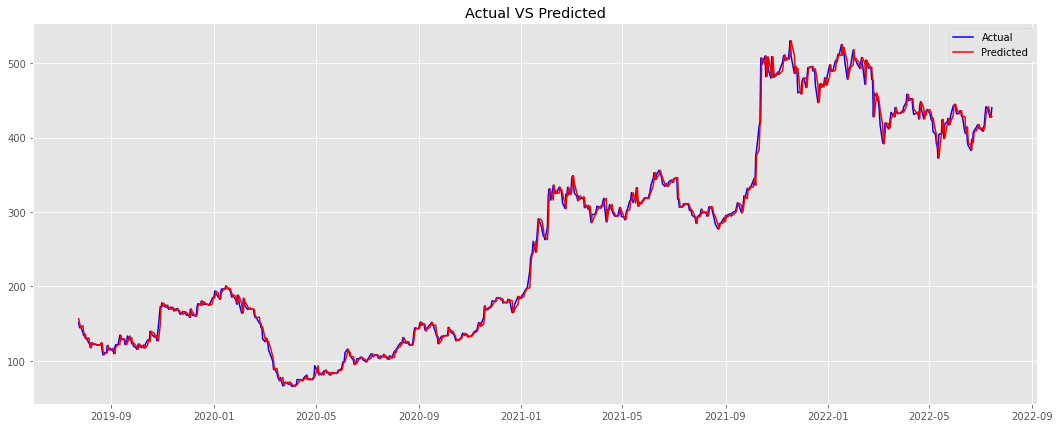

In [187]:
plt.figure(figsize=(18,7))
fig=plt.figure(1)
plt.plot(result["actual"],color='blue',label='Actual')
plt.plot(result["prediction"], color='red', label='Predicted')
plt.legend(loc = 'best')
plt.title('Actual VS Predicted')
plt.show(block = False)

In [188]:
model = ARIMA(y, order=(0,1,0))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [189]:
predictions=pd.Series(model_fit.fittedvalues, copy=True)
print(predictions.head())

Date
2012-07-19    0.000283
2012-07-20    0.000283
2012-07-23    0.000283
2012-07-24    0.000283
2012-07-25    0.000283
dtype: float64


In [190]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

Date
2012-07-19    0.000283
2012-07-20    0.000566
2012-07-23    0.000849
2012-07-24    0.001132
2012-07-25    0.001416
dtype: float64


In [191]:
predictions_log=pd.Series(y, index=y.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log

Date
2012-07-18    5.390205
2012-07-19    5.404825
2012-07-20    5.398861
2012-07-23    5.365690
2012-07-24    5.365047
                ...   
2022-07-11    6.775938
2022-07-12    6.761237
2022-07-13    6.753475
2022-07-14    6.755980
2022-07-15    6.784252
Length: 2463, dtype: float64

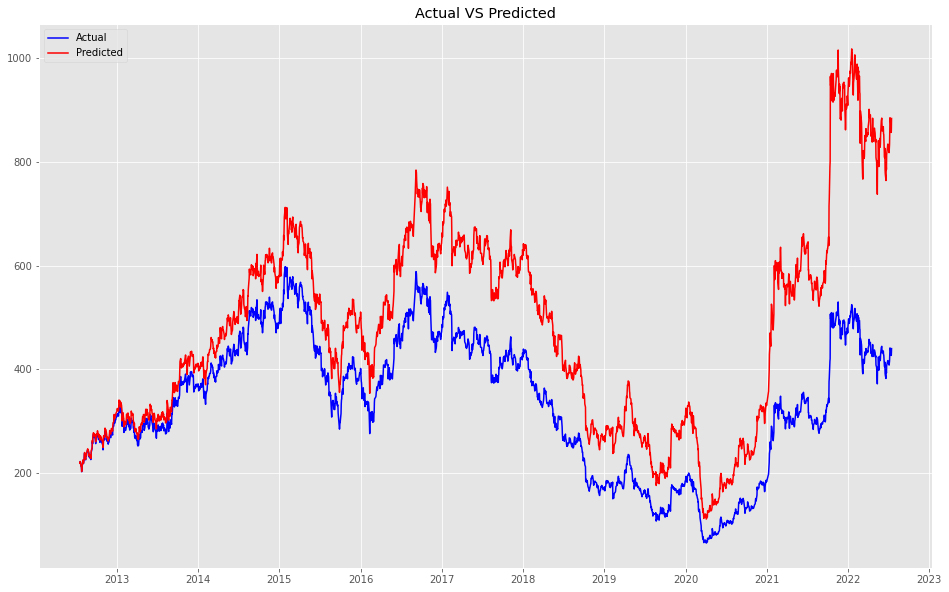

In [192]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(16,10))
plt.plot(df["Close"],color='blue',label='Actual')
plt.plot(predictions_ARIMA,color='red', label='Predicted')
plt.legend(loc = 'best')
plt.title('Actual VS Predicted')
plt.show(block = False)

In [193]:
forecast=model_fit.forecast(steps=9)[0]
np.exp(forecast)

array([440.32465594, 440.44933496, 440.57404928, 440.69879892,
       440.82358388, 440.94840417, 441.07325981, 441.1981508 ,
       441.32307716])

In [194]:
#stock Company for analytics
stock = ['TATAMOTORS.NS']
data_source = 'yahoo' 

# set up Start and End time for data grab
end = datetime.now()
start = datetime(end.year,end.month,end.day-10)

# Set DataFrame as the Stock Ticker
df = pdr.get_data_yahoo(stock,start,end)

[*********************100%***********************]  1 of 1 completed


In [195]:
df['Close']

Date
2022-07-18    450.899994
2022-07-19    449.049988
2022-07-20    453.450012
2022-07-21    454.850006
2022-07-22    454.899994
2022-07-25    449.549988
2022-07-26    441.149994
2022-07-27    444.049988
2022-07-28    431.700012
Name: Close, dtype: float64

In [196]:
result = pd.DataFrame(df['Close'])
result.columns = ["actual"]
result["forecast"] = np.exp(forecast)
result

,actual,forecast
Date,,
2022-07-18,450.899994,440.324656
2022-07-19,449.049988,440.449335
2022-07-20,453.450012,440.574049
2022-07-21,454.850006,440.698799
2022-07-22,454.899994,440.823584
2022-07-25,449.549988,440.948404
2022-07-26,441.149994,441.073260
2022-07-27,444.049988,441.198151
2022-07-28,431.700012,441.323077


In [198]:
error = mean_squared_error(result["actual"] , result["forecast"] )
print('Forecast RMSE: %.3f' % np.sqrt(error))

Forecast RMSE: 10.136
